### pip, import관리, wandia

In [ ]:
import sys
sys.path.append('.') 

#python 3.9.23

# 📦 pip 최신화 (optional)
!{sys.executable} -m pip install pip==25.1.1

# ✅ PyTorch + torchvision (선택한 버전, CUDA 자동 감지 or CPU용 따로 명시 가능)
!{sys.executable} -m pip install torch==2.1.2 torchvision==0.16.2

# 🤖 Transformers (안정 버전)
!{sys.executable} -m pip install transformers==4.53.1

# 🧩 필수 유틸
!{sys.executable} -m pip install einops==0.8.1
!{sys.executable} -m pip install regex
!{sys.executable} -m pip install omegaconf==2.3.0
!{sys.executable} -m pip install "matplotlib>=3.5,<3.9"
!{sys.executable} -m pip install Pillow
!{sys.executable} -m pip install numpy

# 🔤 BPE Tokenizer
!{sys.executable} -m pip install cython
!{sys.executable} -m pip install youtokentome

# 🧠 OpenAI DALL·E 공식 VAE (.pkl 기반)
!{sys.executable} -m pip install git+https://github.com/openai/DALL-E


# 🔁 numpy 재설치 및 버전 다운그레이드 (권장 안정 버전)
!{sys.executable} -m pip install --force-reinstall numpy==1.24.4

!{sys.executable} -m pip install dalle-pytorch taming-transformers-rom1504  

!{sys.executable} -m pip install git+https://github.com/openai/CLIP.git           



In [ ]:
# 기본 유틸
import os
import sys
import random
from glob import glob
import pkg_resources

# PyTorch & 툴킷
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

# 이미지 및 시각화
from PIL import Image
import matplotlib.pyplot as plt

# Tokenizer
import youtokentome as yttm

# 패키지 설치 (한 번만 실행)
!git clone https://github.com/lucidrains/DALLE-pytorch.git
!pip install -e ./DALLE-pytorch
!pip install taming-transformers-rom1504 einops omegaconf regex matplotlib Pillow numpy youtokentome

# 경로 추가
sys.path.append('./DALLE-pytorch')

# DALL·E import
from dalle_pytorch import DALLE, VQGanVAE

# torch 함수들
import torch.nn.functional as F
from einops import rearrange
from math import sqrt
import torch.nn as nn
import torch

from datetime import datetime, timedelta

from torch.utils.data import Dataset
from PIL import Image
import os

from youtokentome import BPE, OutputType 

import wandb
wandb.login(key="9f75da6a26ca1502b0b9429b23f6f3f0feef990d")

from youtokentome import OutputType

import torch
import torch.nn as nn

import torch
from PIL import Image
from torchvision import transforms
import youtokentome as yttm
from dalle_pytorch.vae import VQGanVAE as BaseVQGanVAE

import clip

import os
import json
import shutil
from tqdm import tqdm



### 비교 데이터 로드

### VAE 클래스 정의 및 설치

In [ ]:

class VQGanVAE(BaseVQGanVAE):
    def __init__(self, vqgan_model_path=None, vqgan_config_path=None, from_pretrained=True):
        super().__init__()
        if from_pretrained:
            self.load_ckpt_and_config(vqgan_model_path, vqgan_config_path)
        else:
            self.build_network()

    def build_network(self):
        pass  # 나중에 .pt만 불러쓸 경우 필요한 구조 정의

    def load_ckpt_and_config(self, model_path, config_path):
        # 원래 dalle_pytorch에 있는 VQGanVAE.load_ckpt_and_config 메서드 참고
        import yaml
        from omegaconf import OmegaConf
        from taming.models.vqgan import VQModel
        from taming.models import cond_transformer, vqgan

        # config 불러오기
        config = OmegaConf.load(config_path)
        model = VQModel(**config.model.params)

        # ckpt 로드
        sd = torch.load(model_path, map_location='cpu')['state_dict']
        model.load_state_dict(sd, strict=False)

        # 속성 바인딩
        self.model = model
        self.image_size = 256
        self.num_tokens = 1024
        self.num_layers = 4
        
        
        
def get_codebook_indices(self, img):
    z = self.model.encoder(img)
    z = self.model.quant_conv(z)
    quant, indices, _ = self.model.quantize(z)   # 일반적으로 [B, H, W]

    # 🔒 indices shape 점검 및 보정
    if indices.ndim == 3:
        B, H, W = indices.shape
        indices = indices.view(B, -1)   # [B, H*W]
    elif indices.ndim == 1:
        indices = indices.unsqueeze(0)  # [1, N]
    elif indices.ndim == 0:
        indices = indices.view(1, 1)    # scalar → [1, 1]
    else:
        raise ValueError(f"Unexpected indices shape: {indices.shape}")

    return indices  # ✅ 항상 [B, N] 형태 보장
    
    def forward(self, x):
        return self.model(x)


In [ ]:
from dalle_pytorch.vae import VQGanVAE  # 동일한 모듈에서 로드되어야 함
def load_vae(fast=True, force_yaml=False, debug=True):

    # ✅ VAE 로드
    if fast and not force_yaml and os.path.exists("vqgan_vae.pt"):
        vae = VQGanVAE(
            vqgan_model_path = "vqgan_imagenet_f16_1024/ckpts/last.ckpt",
            vqgan_config_path = "vqgan_imagenet_f16_1024/configs/model.yaml"
        )
        vae.load_state_dict(torch.load("vqgan_vae.pt"))
    else:
        vae = VQGanVAE(
            vqgan_model_path = "vqgan_imagenet_f16_1024/ckpts/last.ckpt",
            vqgan_config_path = "vqgan_imagenet_f16_1024/configs/model.yaml"
        )
        torch.save(vae.state_dict(), "vqgan_vae.pt")

    vae.eval()
#vae 코드북 사이즈 1024 논문에서는 8192


    # ✅ 디버그: 이미지 + 텍스트 → concat 확인
    if debug:
        # sample 이미지 준비
        sample_path = "sample.png"
        if not os.path.exists(sample_path):
            print(f"⚠️ 샘플 이미지 없음: {sample_path}")
            return vae

        # 이미지 전처리
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        image = Image.open(sample_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)  # [1, 3, 256, 256]

        # ✅ 이미지 → 토큰
        with torch.no_grad():
            image_tokens = vae.get_codebook_indices(image_tensor)  # [1, 1024] or [1024] or scalar 등 다양함

        # 안전하게 shape 출력
        image_tokens = image_tokens.view(1, -1)  # 강제로 [1, N] 형태로 바꿔줌
        print("🧠 VAE image token shape:", image_tokens.shape)
        print("    예시 토큰 ID:", image_tokens[0][:10].tolist())

        # ✅ 텍스트 → 토큰
        bpe = yttm.BPE(model="bpe.model")
        prompt = "a red square"
        text_ids = bpe.encode([prompt], output_type=yttm.OutputType.ID)[0]
        text_ids = text_ids[:128] + [0] * (128 - len(text_ids))  # 패딩
        text_tensor = torch.tensor(text_ids).unsqueeze(0)  # [1, 128]

        print("✏️ Text token shape:", text_tensor.shape)  # [1, 128]

        # ✅ concat
        full_input = torch.cat([text_tensor, image_tokens], dim=1)  # [1, 128 + 1024]
        print("📦 Concat된 transformer 입력 shape:", full_input.shape)  # [1, 1152]

    return vae

### COCO데이터셋 처리하기

In [ ]:
#COCO 데이터셋을 DALL·E 학습에 쓸 수 있도록 전처리

# 경로 설정
IMG_DIR = "train2014"
CAPTION_FILE = "annotations/captions_train2014.json"
OUTPUT_DIR = "coco_text_pairs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 캡션 JSON 로드
with open(CAPTION_FILE, 'r') as f:
    data = json.load(f)

# image_id → caption 매핑 (첫 캡션만 사용)
id_to_caption = {}
for ann in data['annotations']:
    img_id = ann['image_id']
    caption = ann['caption']
    if img_id not in id_to_caption:
        id_to_caption[img_id] = caption

# 변환 루프
skipped, converted = 0, 0

for img in tqdm(data['images'], desc="Converting COCO"):
    img_id = img['id']
    filename = img['file_name']
    if img_id not in id_to_caption:
        continue

    src_img = os.path.join(IMG_DIR, filename)
    base = f"{img_id:012d}"
    dst_img = os.path.join(OUTPUT_DIR, f"{base}.jpg")
    dst_txt = os.path.join(OUTPUT_DIR, f"{base}.txt")

    # ✅ 이미 변환된 경우 건너뛰기
    if os.path.exists(dst_img) and os.path.exists(dst_txt):
        skipped += 1
        continue

    if os.path.exists(src_img):
        shutil.copy(src_img, dst_img)
        with open(dst_txt, "w") as f:
            f.write(id_to_caption[img_id])
        converted += 1

# 결과 요약 출력
print(f"✅ 변환 완료: {converted}개 생성, {skipped}개는 이미 존재해서 건너뜀.")

In [ ]:
if not os.path.exists("captions.txt"):
    with open("captions.txt", "w") as out:
        for txt_file in glob("coco_text_pairs/*.txt"):
            with open(txt_file, "r") as f:
                line = f.read().strip()
                out.write(line + "\n")
    print("✅ captions.txt 생성 완료")
else:
    print("✅ captions.txt 이미 존재함 — 건너뜀")

### bpe 모델(caption(text) 2 token) 만들기

In [ ]:
#bpe모델 < 문장의 분할 모델
#논문 BPE 모델 재현, 
yttm.BPE.train(
    data='captions.txt',         # 전체 캡션 텍스트 파일
    model='bpe.model',
    vocab_size=1024
)
#bpe.model완성

bpe = yttm.BPE(model="bpe.model")
#토크나이저 불러온


In [ ]:
class CocoTextPairDataset(Dataset):
    
    
    def __init__(self, folder, tokenizer=None, transform=None, text_seq_len=128, dropout_prob=0.1):#논문에서의 bpe 10% drop 재현
        self.folder = folder
        self.tokenizer = tokenizer
        self.text_seq_len = text_seq_len
        self.transform = transform
        self.dropout_prob = dropout_prob  # ⬅️ 추가
        self.img_paths = []

        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith('.jpg') and 'images' not in os.path.join(root, file):
                    self.img_paths.append(os.path.join(root, file))
        self.img_paths.sort()
  
        
    def __len__(self):
        return len(self.img_paths)


    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        base_name = os.path.splitext(img_path)[0]
        txt_path = f"{base_name}.txt"

        image = Image.open(img_path).convert("RGB")

        with open(txt_path, 'r') as f:
            caption = f.read().strip()

        if self.tokenizer:
            token_ids = self.tokenizer.encode(
                [caption],
                output_type=yttm.OutputType.ID,
                dropout_prob=self.dropout_prob  # 🎯 논문 BPE dropout
            )[0]
            
            # 🔧 길이 고정 + 패딩
            token_ids = token_ids[:self.text_seq_len]
            token_ids += [0] * (self.text_seq_len - len(token_ids))
            
            text = torch.tensor(token_ids)
        else:
            text = None

        if self.transform:
            image = self.transform(image)

        return image, text

In [ ]:
#논문 이미지 증강 재현
class DalleImageAugmentation:
    def __init__(self, target_res=256):
        self.target_res = target_res

    def __call__(self, img):
        from torchvision.transforms import functional as TF
        import random

        w, h = img.size
        s_min = min(w, h)

        # ✅ 최소 크기 체크
        if s_min < self.target_res:
            img = TF.resize(img, [self.target_res, self.target_res])
            return TF.to_tensor(img)

        # 나머지 기존 로직 유지
        off_h = random.randint(3 * (h - s_min) // 8, max(5 * (h - s_min) // 8, 3 * (h - s_min) // 8 + 1))
        off_w = random.randint(3 * (w - s_min) // 8, max(5 * (w - s_min) // 8, 3 * (w - s_min) // 8 + 1))

        img = TF.crop(img, top=off_h, left=off_w, height=s_min, width=s_min)

        t_max = min(s_min, round(9 / 8 * self.target_res))
        if t_max < self.target_res:
            t = self.target_res
        else:
            t = random.randint(self.target_res, t_max)

        img = TF.resize(img, [t, t], interpolation=TF.InterpolationMode.BILINEAR)
        img = TF.center_crop(img, [self.target_res, self.target_res])
        img = TF.to_tensor(img)
        return img

In [ ]:
bpe = yttm.BPE(model="bpe.model")


transform = DalleImageAugmentation(target_res=256)


# 학습용
train_dataset = CocoTextPairDataset(
    folder="coco_text_pairs",
    tokenizer=bpe,
    transform=transform,
    text_seq_len=128,
    dropout_prob=0.1  # 🎯 이게 핵심
)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)


# ✅ 추론/검증용 (BPE dropout 없음)
eval_dataset = CocoTextPairDataset(
    folder="coco_text_pairs",
    tokenizer=bpe,
    transform=transform,
    text_seq_len=128,
    dropout_prob=0.0
)

eval_dataloader = DataLoader(eval_dataset, batch_size=4, shuffle=False)


In [31]:
import youtokentome as yttm

print(bpe.vocab_size())  # => 16384가 나와야 논문과 동일

bpe = yttm.BPE(model='bpe.model')
print("📏 BPE vocab size:", bpe.vocab_size())

vae = load_vae()
print("🎨 Codebook size:", vae.model.quantize.embedding.weight.shape[0])

Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])
🎨 Codebook size: 1024


### 트랜스포머 학습 시작

In [32]:
device = torch.device("cpu")

# ✅ 학습용 VAE
vae = load_vae()
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

# ✅ 학습용 DALL·E
dalle = DALLE(
    vae=vae,
    num_text_tokens=16384,
    text_seq_len=128,
    dim=1024,
    depth=12,
    heads=8,
    dim_head=64
)

dalle.to(device)
dalle.train()

# ✅ 옵티마이저
optimizer = torch.optim.Adam(dalle.parameters(), lr=1e-4)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])


In [33]:
device = torch.device("cpu")

# 💡 VAE는 freeze (미리 학습된 것 사용)
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

# 💾 체크포인트 저장 경로
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

# ⚙️ 학습 설정
dalle.train()
optimizer = torch.optim.Adam(dalle.parameters(), lr=1e-4)



In [34]:
# #조금만 학습해보자!
# num_epochs = 1
# max_batches = 250
# batch_size = 64
# used_captions = set()

# for epoch in range(num_epochs):
#     total_loss = 0.0
#     start_time = datetime.now()  # ⏱️ ETA 계산용 시작 시각
#     pbar = tqdm(enumerate(train_dataloader), total= max_batches, desc = f"Epoch {epoch+1}")

#     for step, (images, tokenized_texts) in pbar:
        
#         if step >= max_batches:  # 🔒 제한된 step까지만 학습
#             break

#         # GPU 또는 MPS 할당
#         images = images.to(device)
#         with torch.no_grad():
#             image_tokens = vae.get_codebook_indices(images)  # ✅ shape: [B, 1024]

#         loss = dalle(
#             text=tokenized_texts,
#             image=image_tokens,     # ✅ image token indices (not raw image)
#             return_loss=True
# )

#         # 🔁 backward + optimizer step
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         avg_loss = total_loss / (step + 1)

#         # ⏳ ETA 계산
#         elapsed = (datetime.now() - start_time).total_seconds()
#         avg_time_per_step = elapsed / (step + 1)
#         remaining = max_batches - (step + 1)
#         eta = timedelta(seconds=int(avg_time_per_step * remaining))
#         eta_str = (datetime.now() + eta).strftime('%H:%M:%S')
        
#         for path in train_dataset.img_paths[step * batch_size:(step + 1) * batch_size]:
#             base_name = os.path.splitext(os.path.basename(path))[0]  # 예: 000000000009
#             txt_path = os.path.join("coco_text_pairs", f"{base_name}.txt")
#             with open(txt_path, 'r') as f:
#                 used_captions.add(f.read().strip())

#     # epoch 끝나고 loss 출력
#     print(f"[Epoch {epoch+1}] Average Loss: {avg_loss:.4f}")

#     # 🧠 모델 저장
#     torch.save(dalle.state_dict(), os.path.join(save_dir, f"dalle_epoch{epoch+1}.pt"))

### 학습 완료, 불러오자

In [35]:
from dalle_pytorch import DALLE

def load_dalle(vae):
    return DALLE(
        vae=vae,
        num_text_tokens=16384,   # BPE vocab size
        text_seq_len=128,        # 텍스트 시퀀스 길이
        dim=1024,                # transformer hidden dim
        depth=12,                # transformer layer 수
        heads=8,                 # multi-head attention 수
        dim_head=64              # 각 head 차원
    )

In [36]:
#use mine
dalle_target_path = 'checkpoints/dalle_epoch1.pt'

# ✅ VAE 로드
vae = load_vae()

# ✅ 통일된 DALL·E 구조로 초기화
dalle = load_dalle(vae)

# ✅ 가중치 불러오기
dalle.load_state_dict(torch.load(dalle_target_path, map_location=device))
dalle.eval()

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])


DALLE(
  (vae): VQGanVAE(
    (model): VQModel(
      (encoder): Encoder(
        (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down): ModuleList(
          (0-1): 2 x Module(
            (block): ModuleList(
              (0-1): 2 x ResnetBlock(
                (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
                (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
            )
            (attn): ModuleList()
            (downsample): Downsample(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
          (2): Module(
            (block): ModuleList(
              (0): ResnetBlock(
                (norm1): GroupNorm(32, 128, e

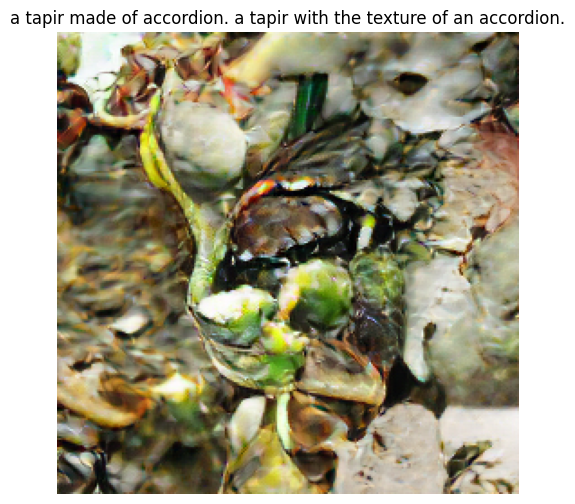

In [37]:
prompt = "a tapir made of accordion. a tapir with the texture of an accordion."

# ✅ 리스트로 감싸서 인코딩
tokens = bpe.encode([prompt], output_type=OutputType.ID)[0]
tokens = tokens[:128] + [0] * (128 - len(tokens))

text_token = torch.tensor(tokens).unsqueeze(0).to(device)

# 이미지 생성
dalle.eval()
with torch.no_grad():
    generated_images = dalle.generate_images(text_token)

# 결과 시각화
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

grid = make_grid(generated_images, nrow=1)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(prompt)
plt.show()

### pretrained?? https://github.com/robvanvolt/DALLE-models

In [38]:
def pad_tokens(token_ids, max_len=256):
    if len(token_ids) > max_len:
        return token_ids[:max_len]
    else:
        return token_ids + [0] * (max_len - len(token_ids))
def clip_tokens(token_ids, max_token_id):
    return [min(t, max_token_id) for t in token_ids]

def generate_images_for_models(model_paths, pairs, bpe):
    all_results = []

    for model_path in model_paths:
        print(f"Loading model: {os.path.basename(model_path)}")  # 모델명 출력
        checkpoint = torch.load(model_path, map_location=device)
        hparams = checkpoint.get("hparams", {})
        state_dict = checkpoint.get("weights", checkpoint)

        vae = load_vae()
        dalle = DALLE(
            vae=vae,
            num_text_tokens=hparams.get("num_text_tokens", 10000),
            text_seq_len=hparams.get("text_seq_len", 128),
            dim=hparams.get("dim", 544),
            depth=hparams.get("depth", 12),
            heads=hparams.get("heads", 8),
            dim_head=hparams.get("dim_head", 64)
        )

        def load_partial_state_dict(model, checkpoint_state_dict):
            model_state_dict = model.state_dict()
            filtered_dict = {}
            for k, v in checkpoint_state_dict.items():
                if k in model_state_dict and v.shape == model_state_dict[k].shape:
                    filtered_dict[k] = v
            model_state_dict.update(filtered_dict)
            model.load_state_dict(model_state_dict)

        load_partial_state_dict(dalle, state_dict)

        dalle.to(device)
        dalle.eval()

        max_token_id = hparams.get("num_text_tokens", 10000) - 1

        for pair in tqdm(pairs, desc=os.path.basename(model_path)):
            prompt = pair["prompt"]

            with torch.no_grad():
                token_ids = bpe.encode([prompt], output_type=yttm.OutputType.ID)[0]
                # 토큰 id가 범위 밖이면 최대 토큰 id로 클리핑
                token_ids = clip_tokens(token_ids, max_token_id)
                padded_tokens = pad_tokens(token_ids, max_len=hparams.get("text_seq_len", 128))
                text = torch.tensor(padded_tokens).unsqueeze(0).to(device)

                generated = dalle.generate_images(text, filter_thres=0.9)
                gen_img = transforms.ToPILImage()(generated.squeeze(0).cpu())

            print(f"Model: {os.path.basename(model_path)}")
            print(f"Prompt: {prompt}")
            display(gen_img)  # 주피터 노트북에서 이미지 출력

            all_results.append({
                "model": os.path.basename(model_path),
                "prompt": prompt,
                "image": gen_img
            })

    return all_results


Loading model: conceptual_cc_dalle.pt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])


conceptual_cc_dalle.pt:   0%|          | 0/1 [00:00<?, ?it/s]

Model: conceptual_cc_dalle.pt
Prompt: a tapir made of accordion. a tapir with the texture of an accordion.


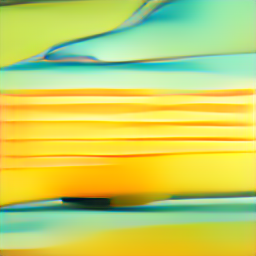

conceptual_cc_dalle.pt: 100%|██████████| 1/1 [00:27<00:00, 27.29s/it]

Loading model: dalle_epoch1.pt


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])


dalle_epoch1.pt:   0%|          | 0/1 [00:00<?, ?it/s]

Model: dalle_epoch1.pt
Prompt: a tapir made of accordion. a tapir with the texture of an accordion.


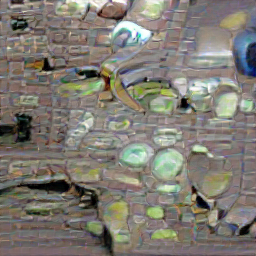

dalle_epoch1.pt: 100%|██████████| 1/1 [00:16<00:00, 16.77s/it]

Loading model: experimental_dalle.pt


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])


experimental_dalle.pt:   0%|          | 0/1 [00:00<?, ?it/s]

Model: experimental_dalle.pt
Prompt: a tapir made of accordion. a tapir with the texture of an accordion.


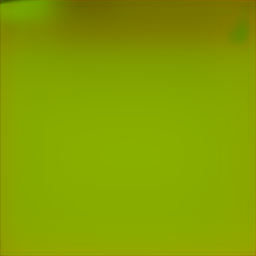

experimental_dalle.pt: 100%|██████████| 1/1 [00:14<00:00, 14.85s/it]

Loading model: royalty_free_dalle.pt


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Loaded VQGAN from vqgan_imagenet_f16_1024/ckpts/last.ckpt and vqgan_imagenet_f16_1024/configs/model.yaml
🧠 VAE image token shape: torch.Size([1, 256])
    예시 토큰 ID: [862, 261, 330, 813, 813, 813, 813, 564, 813, 873]
✏️ Text token shape: torch.Size([1, 128])
📦 Concat된 transformer 입력 shape: torch.Size([1, 384])


royalty_free_dalle.pt:   0%|          | 0/1 [00:00<?, ?it/s]

Model: royalty_free_dalle.pt
Prompt: a tapir made of accordion. a tapir with the texture of an accordion.


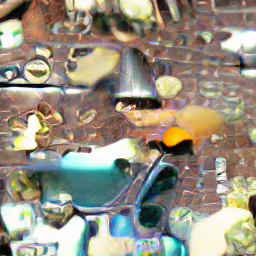

royalty_free_dalle.pt: 100%|██████████| 1/1 [00:18<00:00, 18.10s/it]


In [47]:
prompt = "a tapir made of accordion. a tapir with the texture of an accordion."
pre_prompt = [{"prompt": prompt}]  # ✅ 리스트 안에 dict로 감싸기

bpe = yttm.BPE(model="bpe.model")
model_dir = "pretrainedmodels_collected_dalle"
usable_models = [
    "conceptual_cc_dalle.pt",
    "dalle_epoch1.pt",
    "experimental_dalle.pt",
    "royalty_free_dalle.pt"
]
model_paths = [os.path.join(model_dir, m) for m in usable_models]

results = generate_images_for_models(model_paths, pre_prompt, bpe)